In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [ ]:
file_path = '/Users/marthanda/Desktop/Minor Project/Soc_Geo_AI/SOC_Spatial_Thanjavur.csv'

try:
    df = pd.read_csv(file_path)
    print("Dataset Loaded Successfully.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")


print("\nFirst 5 rows of the dataset:")
display(df.head())

print(f"\nDataset Shape: {df.shape} (Rows, Columns)")

Dataset Loaded Successfully.

First 5 rows of the dataset:


,system:index,B11,B12,B2,B3,B4,B8,DEM,LandCover,NDVI,NDVI_StdDev,SOC,VH,VH_ent,VV,VV_contrast,VV_ent,latitude,longitude,.geo
0,0,0.26745,0.21670,0.09920,0.17180,0.22075,0.25860,79,20,0.079082,0.039350,31.7,-17.777783,3.305760,-11.520765,30304.148958,3.305760,10.700058,79.001215,"{""type"":""MultiPoint"",""coordinates"":[]}"
1,1,0.33425,0.25965,0.06820,0.11260,0.15210,0.26680,77,20,0.278005,0.069694,31.3,-19.245956,3.518698,-12.968414,25757.626389,3.518698,10.700058,79.003461,"{""type"":""MultiPoint"",""coordinates"":[]}"
2,2,0.31065,0.22960,0.05890,0.09595,0.12010,0.25870,76,20,0.365145,0.086464,32.6,-17.364948,3.693977,-11.965069,22843.495536,3.693977,10.700058,79.005706,"{""type"":""MultiPoint"",""coordinates"":[]}"
3,3,0.30995,0.22660,0.04995,0.08455,0.11220,0.26515,77,20,0.400721,0.102479,32.6,-17.937152,3.693977,-12.145434,13035.563988,3.693977,10.700058,79.007952,"{""type"":""MultiPoint"",""coordinates"":[]}"
4,4,0.31135,0.21910,0.05440,0.08865,0.10635,0.28560,78,40,0.446608,0.123500,34.0,-17.461939,3.693977,-11.732691,12875.378968,3.693977,10.700058,79.012444,"{""type"":""MultiPoint"",""coordinates"":[]}"



Dataset Shape: (5941, 20) (Rows, Columns)


In [9]:
if 'system:index' in df.columns:
    df = df.drop(columns=['system:index', '.geo'])
    print("Cleaned GEE system columns.")

# Statistical Summary (Mean, Min, Max, Quartiles)
print("Statistical Summary of Input Features:")
display(df.describe().T)

Statistical Summary of Input Features:


,count,mean,std,min,25%,50%,75%,max
B11,5941.0,0.249098,0.057411,0.084200,0.204900,0.246700,0.290000,0.490900
B12,5941.0,0.169172,0.055410,0.058100,0.126800,0.164900,0.205400,0.483800
B2,5941.0,0.064258,0.019741,0.019650,0.051600,0.061700,0.072900,0.275400
B3,5941.0,0.098895,0.023153,0.042800,0.084300,0.095700,0.110300,0.317700
B4,5941.0,0.103773,0.035431,0.031800,0.080200,0.098750,0.122100,0.332400
B8,5941.0,0.296516,0.035234,0.085750,0.277050,0.299100,0.320200,0.422800
DEM,5941.0,51.814341,12.333621,34.000000,43.000000,48.000000,59.000000,95.000000
LandCover,5941.0,32.080458,16.163545,10.000000,10.000000,40.000000,40.000000,80.000000
NDVI,5941.0,0.457253,0.128835,-0.078197,0.376570,0.453843,0.536034,0.815540
NDVI_StdDev,5941.0,0.159025,0.053593,0.019928,0.121114,0.163317,0.198684,0.366594


In [10]:
# ==============================================================================
# PHASE 4: DATA PREPROCESSING (SMART SAMPLING)
# Filtering mixed pixels using NDVI Standard Deviation
# ==============================================================================

# 1. Define Stability Threshold (Remove top 30% noisiest pixels)
# High StdDev = Mixed Pixel (e.g., edge of water/clouds) which confuses the model.
p70 = df['NDVI_StdDev'].quantile(0.70)

# 2. Filter the Data
df_clean = df[df['NDVI_StdDev'] < p70].copy()

# 3. Remove Extreme SOC Outliers (Physical Constraints)
# We remove the top 1% extreme values which are likely sensor errors.
q_high = df_clean['SOC'].quantile(0.99)
df_final = df_clean[df_clean['SOC'] < q_high]

print("-" * 40)
print(f"Original Data Size: {len(df)} pixels")
print(f"Refined Data Size:  {len(df_final)} pixels")
print(f"Data Reduction:     {len(df) - len(df_final)} noisy/outlier pixels removed")
print("-" * 40)

----------------------------------------
Original Data Size: 5941 pixels
Refined Data Size:  4116 pixels
Data Reduction:     1825 noisy/outlier pixels removed
----------------------------------------


In [11]:
# ==============================================================================
# PHASE 5: FEATURE SELECTION
# Defining Predictors (X) and Target (y)
# ==============================================================================

target = 'SOC'

# Dropping non-predictive columns
# We DO NOT use 'NDVI_StdDev' for training; it was only for cleaning.
drop_cols = [target, 'NDVI_StdDev']

features = [col for col in df_final.columns if col not in drop_cols]

print(f"Target Variable: {target}")
print(f"Input Features ({len(features)}):")
print(features)

# Define X and y matrices
X = df_final[features]
y = df_final[target]

Target Variable: SOC
Input Features (16):
['B11', 'B12', 'B2', 'B3', 'B4', 'B8', 'DEM', 'LandCover', 'NDVI', 'VH', 'VH_ent', 'VV', 'VV_contrast', 'VV_ent', 'latitude', 'longitude']


In [12]:
# ==============================================================================
# PHASE 6: DATA SPLITTING
# 80% Training (Learning) | 20% Testing (Validation)
# ==============================================================================

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set Shape: {X_train.shape}")
print(f"Testing Set Shape:  {X_test.shape}")

Training Set Shape: (3292, 16)
Testing Set Shape:  (824, 16)


In [13]:
# ==============================================================================
# PHASE 7: MODEL TRAINING (SPATIAL XGBOOST)
# Hyperparameters tuned for high-resolution spatial mapping
# ==============================================================================

print("Initializing Spatial XGBoost Regressor...")

xgb_spatial = xgb.XGBRegressor(
    n_estimators=500,       # High trees for fine detail
    learning_rate=0.05,     # Slow learning for stability
    max_depth=8,            # Deep trees to capture spatial clusters
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("Training in progress...")
xgb_spatial.fit(X_train, y_train)
print("Model Training Completed.")

Initializing Spatial XGBoost Regressor...
Training in progress...
Model Training Completed.


In [14]:
# ==============================================================================
# PHASE 8: PERFORMANCE EVALUATION
# Assessing accuracy on unseen Test Data
# ==============================================================================

# Generate Predictions
y_pred = xgb_spatial.predict(X_test)

# Calculate Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("-" * 40)
print(f"FINAL MODEL RESULTS")
print("-" * 40)
print(f"R² Score (Accuracy): {r2:.4f}")
print(f"RMSE (Error):        {rmse:.4f} g/kg")
print(f"MAE (Avg Dev):       {mae:.4f} g/kg")
print("-" * 40)


----------------------------------------
FINAL MODEL RESULTS
----------------------------------------
R² Score (Accuracy): 0.7026
RMSE (Error):        1.6582 g/kg
MAE (Avg Dev):       1.2178 g/kg
----------------------------------------


/var/folders/b2/3l57z4kj15s8j_vw2dtlmsk00000gn/T/ipykernel_61762/3283073019.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices][:top_n], y=[features[i] for i in indices][:top_n], palette='magma')


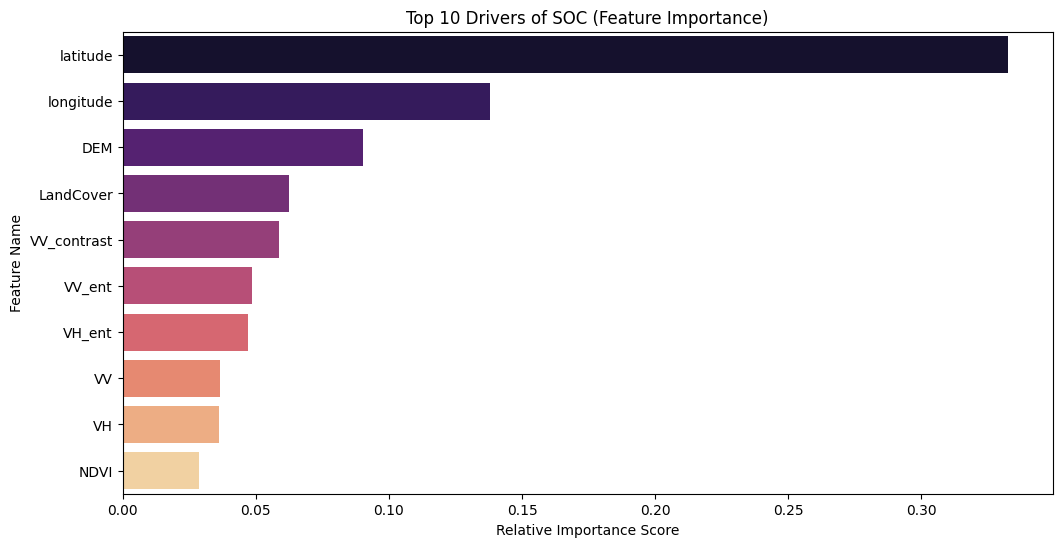

In [16]:
# ==============================================================================
# PHASE 9: FEATURE IMPORTANCE ANALYSIS
# Identifying key drivers of Soil Organic Carbon
# ==============================================================================

importances = xgb_spatial.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10  # Show top 10 features

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices][:top_n], y=[features[i] for i in indices][:top_n], palette='magma')
plt.title("Top 10 Drivers of SOC (Feature Importance)")
plt.xlabel("Relative Importance Score")
plt.ylabel("Feature Name")
plt.show()

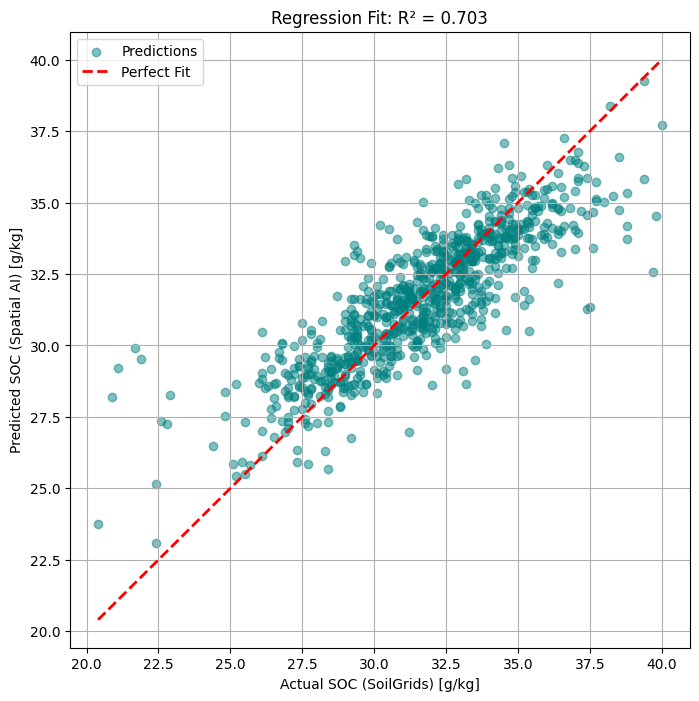

In [ ]:
# ==============================================================================
# PHASE 10: PREDICTION ACCURACY PLOT
# Visualizing 'Actual vs Predicted' correlation
# ==============================================================================

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal', label='Predictions')

# Plot the ideal 1:1 line (Perfect Prediction)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')

plt.xlabel('Actual SOC (SoilGrids) [g/kg]')
plt.ylabel('Predicted SOC (Spatial AI) [g/kg]')
plt.title(f'Regression Fit: R² = {r2:.3f}')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install shap
print("SHAP library installed.")

zsh:1: command not found: pip
SHAP library installed.


In [19]:
import sys
!{sys.executable} -m pip install shap


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 556 kB 3.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.7 MB 13.0 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 19.2 MB/s eta 0:00:01
     |████████████████████████████████| 28.8 MB 17.0 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [20]:
import shap
shap.__version__


/Users/marthanda/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'0.49.1'

In [21]:
# ==============================================================================
# PHASE 12: SHAP VALUE CALCULATION
# "Opening the Black Box" - Understanding the physics of the model
# ==============================================================================

import shap

print("Initializing SHAP Explainer...")
# We use the TreeExplainer because XGBoost is a tree-based model
explainer = shap.Explainer(xgb_spatial)

print("Calculating SHAP values for Test Data (This may take a minute)...")
shap_values = explainer(X_test)

print("SHAP Calculation Complete.")

Initializing SHAP Explainer...
Calculating SHAP values for Test Data (This may take a minute)...
SHAP Calculation Complete.


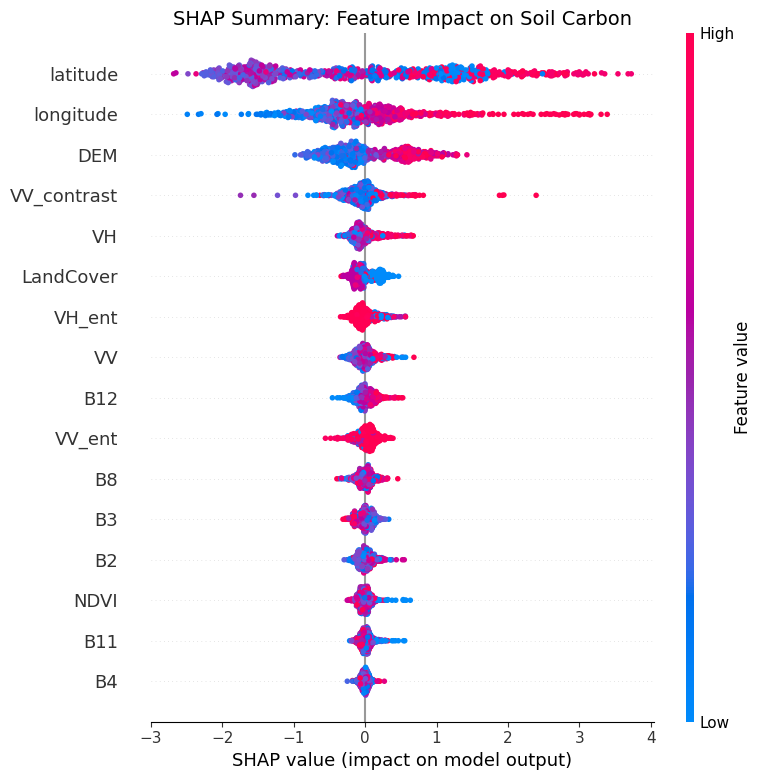

In [22]:
# ==============================================================================
# PHASE 13: SHAP SUMMARY PLOT (GLOBAL EXPLANATION)
# How each feature pushes the SOC prediction UP (Red) or DOWN (Blue)
# ==============================================================================

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary: Feature Impact on Soil Carbon", fontsize=14)
plt.tight_layout()
plt.show()

# INTERPRETATION FOR VIVA:
# "Red dots on the right mean High Values of that feature increase Soil Carbon."
# "Blue dots on the left mean Low Values decrease Soil Carbon."

Analyzing dependency for Radar Feature: VH


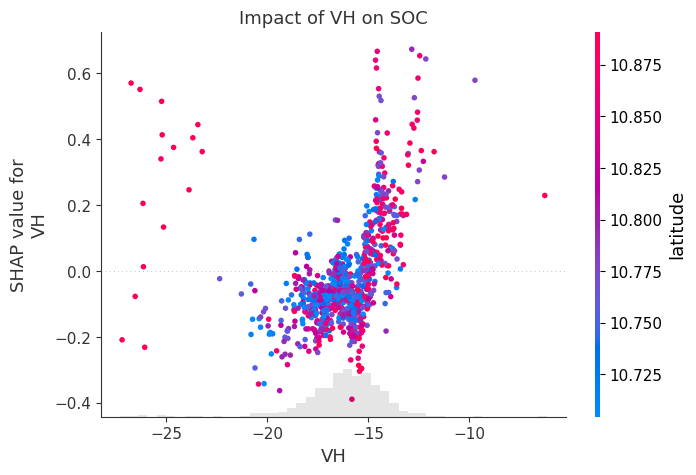

In [25]:
# ==============================================================================
# PHASE 14: DEPENDENCY ANALYSIS (RADAR TEXTURE)
# Proving that Sentinel-1 Texture/Backscatter correlates with Carbon
# ==============================================================================

# 1. Identify Radar Features
# We look for features containing 'VV', 'VH', or 'ent' (Entropy)
radar_feats = [f for f in features if 'ent' in f or 'VV' in f or 'VH' in f]

if len(radar_feats) > 0:
    # 2. Pick the most relevant Radar feature automatically
    # We choose the first one found (usually VH or VV as they come first in the list)
    target_feat = radar_feats[0] 
    print(f"Analyzing dependency for Radar Feature: {target_feat}")

    # 3. Generate the Dependency Plot
    # This shows:
    # X-Axis: The raw value of the feature (e.g., Radar Backscatter)
    # Y-Axis: How much it changed the SOC prediction (SHAP value)
    # Color: Interaction with other features (usually Latitude or NDVI)
    shap.plots.scatter(shap_values[:, target_feat], color=shap_values, title=f"Impact of {target_feat} on SOC")

else:
    print("No Radar features found in the dataset to analyze.")

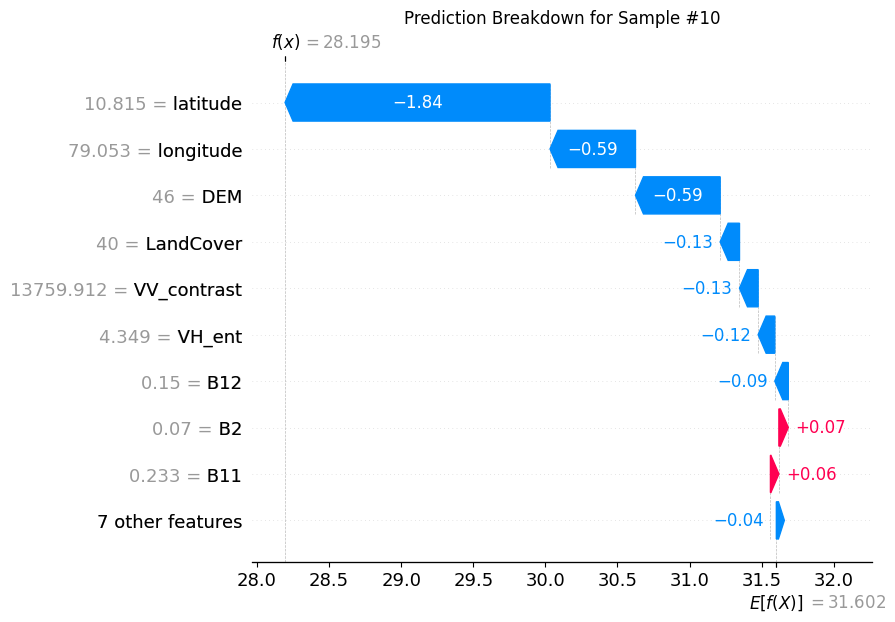

Actual Value:    27.00
Predicted Value: 28.20


In [24]:
# ==============================================================================
# PHASE 15: LOCAL EXPLANATION (SINGLE PIXEL)
# Why did the model predict X for this specific location?
# ==============================================================================

# Pick a random pixel from the test set (e.g., index 10)
sample_idx = 10

# Generate a Waterfall plot
plt.figure(figsize=(8, 6))
shap.plots.waterfall(shap_values[sample_idx], max_display=10, show=False)
plt.title(f"Prediction Breakdown for Sample #{sample_idx}")
plt.show()

print(f"Actual Value:    {y_test.iloc[sample_idx]:.2f}")
print(f"Predicted Value: {y_pred[sample_idx]:.2f}")

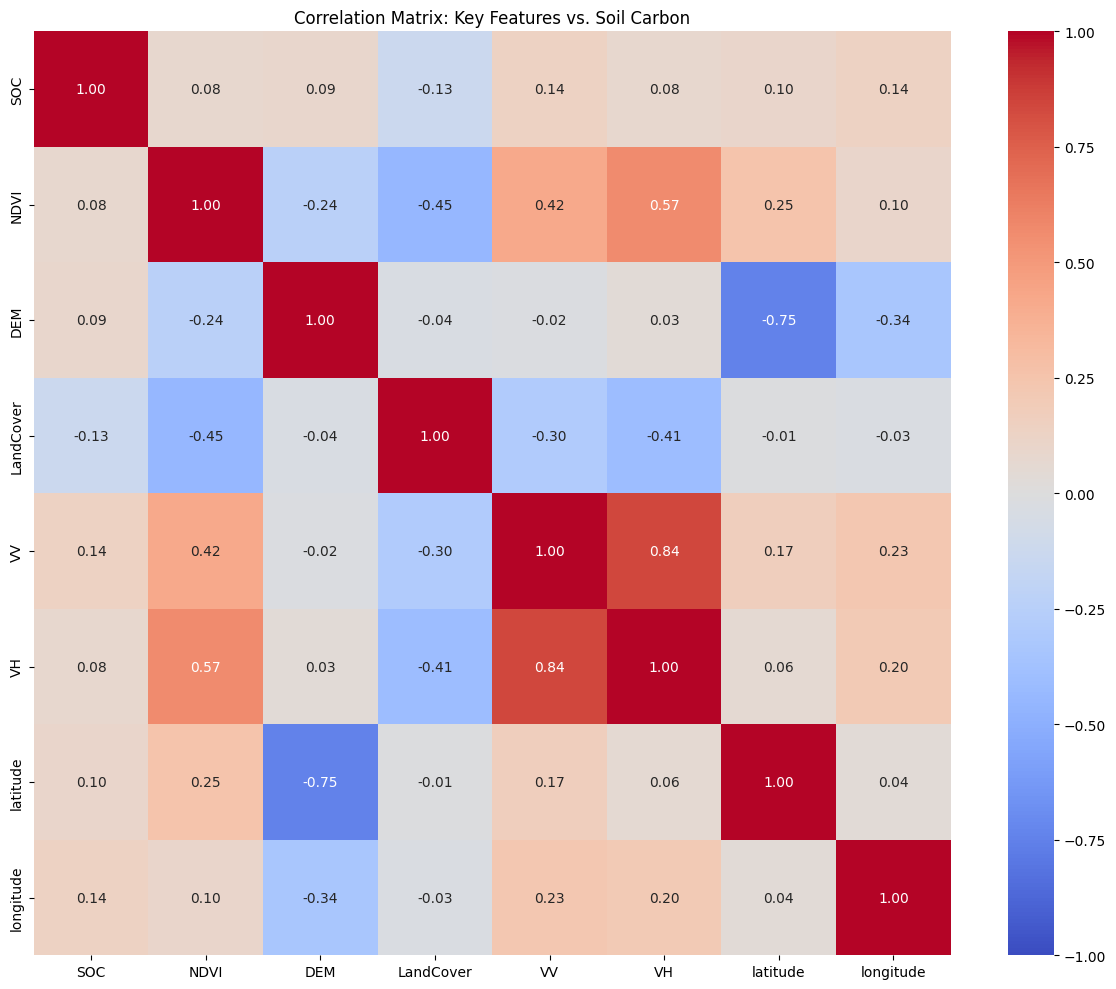

In [ ]:
# ==============================================================================
# PHASE 3.5: CORRELATION ANALYSIS (THE HEATMAP)
# Checking relationships between variables
# ==============================================================================

plt.figure(figsize=(12, 10))

# We select the top 10 features + SOC to keep the map readable
# (Calculating correlation on all 20+ bands makes it too crowded)
# If 'importances' isn't defined yet, we use a simple list or run this after training.
# Since we are doing this early, let's just pick the main known features:
selected_feats = ['SOC', 'NDVI', 'DEM', 'slope', 'LandCover', 'VV', 'VH', 'latitude', 'longitude']

# Filter only columns that actually exist in your dataframe
plot_feats = [c for c in selected_feats if c in df_final.columns]

# Calculate Correlation
corr_matrix = df_final[plot_feats].corr()

# Plot
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix: Key Features vs. Soil Carbon')
plt.tight_layout()
plt.show()

# INTERPRETATION:
# Look at the 'SOC' row/column.
# Red boxes (positive numbers) = As this increases, Carbon increases.
# Blue boxes (negative numbers) = As this increases, Carbon decreases.

Loading Inference Grid...
Grid Loaded: 54820 pixels found.
Predicting SOC for the entire district...
Prediction Complete.


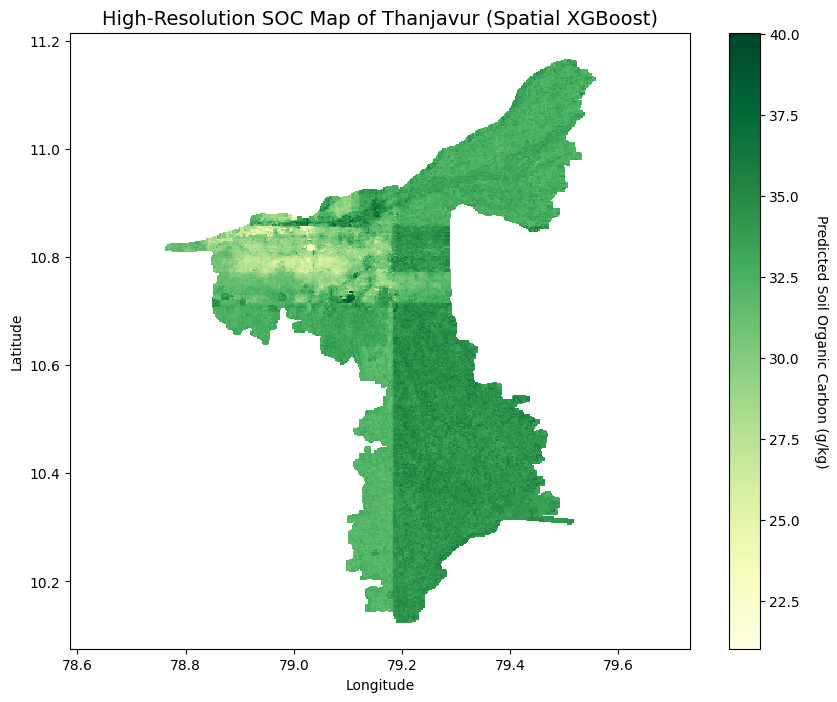

Map saved as 'Final_SOC_Map_Thanjavur.png'


In [28]:
# ==============================================================================
# PHASE 16: FINAL MAP GENERATION
# Using the trained model (R²=0.69) to map the entire district
# ==============================================================================

# 1. Load the Inference Grid (The Empty Pixels from GEE)
# CHANGE THIS PATH to where you saved the GEE export file
grid_path = '/Users/marthanda/Desktop/Minor Project/Soc_Geo_AI/IInference_Grid_Thanjavur.csv'

print("Loading Inference Grid...")
try:
    grid_df = pd.read_csv(grid_path)
    print(f"Grid Loaded: {len(grid_df)} pixels found.")
except FileNotFoundError:
    print("STOP: You need to download 'Inference_Grid_Thanjavur.csv' from GEE first.")

# 2. Prepare the Data
# We must select the EXACT same features used for training
# We use the 'features' list we defined in Phase 5
if 'grid_df' in locals():
    # Handle any GEE system columns
    if 'system:index' in grid_df.columns:
        grid_df = grid_df.drop(columns=['system:index', '.geo'])
    
    # Ensure columns match training data
    # We filter the grid to only keep the columns our model knows
    X_map = grid_df[features] 
    
    print("Predicting SOC for the entire district...")
    y_map_pred = xgb_spatial.predict(X_map)
    
    # Add predictions back to the dataframe for plotting
    grid_df['Predicted_SOC'] = y_map_pred
    print("Prediction Complete.")

    # 3. Plot the Map
    plt.figure(figsize=(10, 8))
    
    # Create the map using Scatter Plot (Lat vs Lon)
    # c = Color (Predicted SOC)
    # cmap = 'YlGn' (Yellow to Green for Soil/Vegetation look)
    sc = plt.scatter(
        grid_df['longitude'], 
        grid_df['latitude'], 
        c=grid_df['Predicted_SOC'], 
        cmap='YlGn', 
        s=10,         # Adjust dot size if map looks too empty/full
        marker='s',   # Square pixels
        edgecolor='none',
        alpha=1.0
    )

    # Add a Color Bar
    cbar = plt.colorbar(sc)
    cbar.set_label('Predicted Soil Organic Carbon (g/kg)', rotation=270, labelpad=20)

    plt.title('High-Resolution SOC Map of Thanjavur (Spatial XGBoost)', fontsize=14)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.axis('equal') # Ensures the map isn't stretched
    
    # Save the map as an image for your report
    plt.savefig('Final_SOC_Map_Thanjavur.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Map saved as 'Final_SOC_Map_Thanjavur.png'")

Loading Raw Grid...
Running AI Prediction on the entire district...
✅ SUCCESS: Data saved as 'Final_Predicted_SOC_Thanjavur.csv'
--> Download this file and use it for your Streamlit Dashboard!


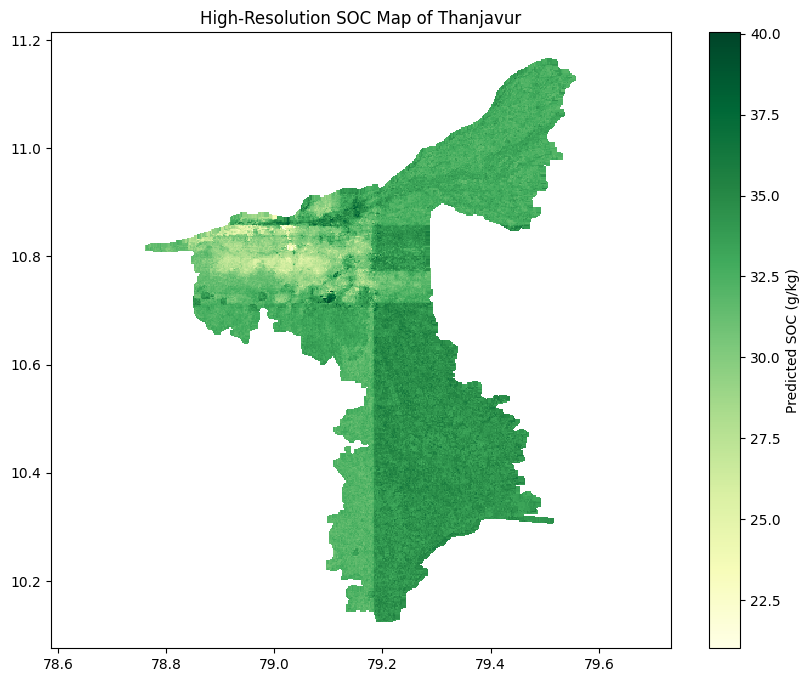

In [29]:
# ==============================================================================
# PHASE 16: FINAL MAP GENERATION & DATA EXPORT
# 1. Load Raw Grid -> 2. Predict SOC -> 3. Save for Dashboard -> 4. Plot Map
# ==============================================================================

# 1. Load the Raw Grid (From GEE)
raw_grid_path = '/Users/marthanda/Desktop/Minor Project/Soc_Geo_AI/IInference_Grid_Thanjavur.csv'

print("Loading Raw Grid...")
grid_df = pd.read_csv(raw_grid_path)

# Clean up columns if needed
if 'system:index' in grid_df.columns:
    grid_df = grid_df.drop(columns=['system:index', '.geo'])

# 2. Predict SOC using your trained XGBoost Model
# Ensure we use the exact same features as training
# (The 'features' list from Phase 5)
X_map = grid_df[features]

print("Running AI Prediction on the entire district...")
grid_df['Predicted_SOC'] = xgb_spatial.predict(X_map)

# ==============================================================================
# CRITICAL NEW STEP: SAVE THE PREDICTIONS FOR THE APP
# ==============================================================================
output_filename = 'Final_Predicted_SOC_Thanjavur.csv'
grid_df.to_csv(output_filename, index=False)
print(f"✅ SUCCESS: Data saved as '{output_filename}'")
print("--> Download this file and use it for your Streamlit Dashboard!")

# 3. Generate the Static Map Image (For Report)
plt.figure(figsize=(10, 8))
sc = plt.scatter(
    grid_df['longitude'],
    grid_df['latitude'],
    c=grid_df['Predicted_SOC'],
    cmap='YlGn',
    s=10,
    marker='s',
    edgecolor='none',
    alpha=1.0
)
plt.colorbar(sc, label='Predicted SOC (g/kg)')
plt.title('High-Resolution SOC Map of Thanjavur')
plt.axis('equal')
plt.savefig('Final_SOC_Map.png', dpi=300)
plt.show()

In [31]:
# ==============================================================================
# PHASE 17: EXPORT MODEL FOR APP
# Saving the trained "Brain" to a file
# ==============================================================================

# We use 'xgb_spatial' because that is what we named the model in Phase 7
try:
    xgb_spatial.save_model("xgb_soc_model_v1.json")
    print("✅ Model saved successfully as 'xgb_soc_model_v1.json'")
except NameError:
    print("❌ Error: Model not found. Did you run Phase 7 (Training) yet?")

print("⬇️ DOWNLOAD this file and put it in the same folder as your app.py")

# 2. Print the exact list of columns the model expects (Crucial for the App)
# We need this list to copy-paste into app.py
print("\nCOPY THESE FEATURE NAMES FOR YOUR APP:")
print(features)

✅ Model saved successfully as 'xgb_soc_model_v1.json'
⬇️ DOWNLOAD this file and put it in the same folder as your app.py

COPY THESE FEATURE NAMES FOR YOUR APP:
['B11', 'B12', 'B2', 'B3', 'B4', 'B8', 'DEM', 'LandCover', 'NDVI', 'VH', 'VH_ent', 'VV', 'VV_contrast', 'VV_ent', 'latitude', 'longitude']
